# Experiment 9.11 - Causal Inverse RL

In [1]:
from torch.optim import Adam
import matplotlib.pyplot as plt

from gymnasium import spaces
from causal_gym import Graph, SCM, PCH
from imitation.imitate import *
from imitation.gym_gail.core_net import DiscreteActor, Critic, Discriminator
from imitation.gym_gail.causal_gail import *

In [2]:
seed = 0
device = 'cpu'

### Define causal graph, SCM, & PCH

In [3]:
# define causal graph
nodes = [{'name': n} for n in ['Z0', 'X0', 'Z1', 'X1', 'Y']]
edges = [
    {'from_': 'Z0', 'to_': 'Z1', 'type_': 'bidirected'},
    {'from_': 'Z0', 'to_': 'Y', 'type_': 'bidirected'},
    {'from_': 'Z1', 'to_': 'X1', 'type_': 'bidirected'},
    {'from_': 'Z1', 'to_': 'X1', 'type_': 'directed'},
    {'from_': 'X0', 'to_': 'Y', 'type_': 'directed'},
    {'from_': 'X1', 'to_': 'Y', 'type_': 'directed'},
    {'from_': 'Z1', 'to_': 'Y', 'type_': 'directed'},
]
G = Graph(nodes=nodes, edges=edges)

In [4]:
class E911SCM(SCM):
    def __init__(self, graph, seed=None):
        super().__init__()
        self.rng = np.random.default_rng(seed)

        self.graph = graph

        self._U = [] # U1, U2, U3, U4
        self.Z = []
        self.X = []
        self._Y = [] # 5-element vector w/ xors

        self.action_space = spaces.Discrete(2) # binary actions at each step
        self.observation_space = spaces.Dict({
            'Z': spaces.Sequence(spaces.Discrete(2)),
            'X': spaces.Sequence(spaces.Discrete(2))
        })

    def _sample_confounders(self):
        U1 = self.rng.choice([0, 1], p=[0.2, 0.8])
        U2 = self.rng.choice([0, 1], p=[0.2, 0.8])
        U3 = self.rng.choice([0, 1], p=[0.8, 0.2])
        U4 = self.rng.choice([0, 1], p=[0.9, 0.1])
        return [U1, U2, U3, U4]

    def _sample_z(self):
        if self._t == 0:
            return self._U[0] ^ self._U[2]
        else:
            return self.Z[0] ^ self._U[1] ^ self._U[3]        

    def _obs(self):
        return {'Z': self.Z, 'X': self.X}

    def reset(self, seed=None, options=None):
        if seed is not None:
            self.rng = np.random.default_rng(seed)

        self._t = 0
        self._U = self._sample_confounders()
        self.X = []
        self.Z = [self._sample_z()]

        return self._obs(), {'Y': []}

    def action(self):
        if self._t == 0:
            return self.rng.choice([0, 1], p=[0.32, 0.68])
        else:
            return self._U[1] ^ self.Z[1]

    def _reward(self):
        return self.X[0] ^ self.X[1] ^ self.Z[0] ^ self.Z[1] ^ self._U[3]

    def step(self, action):
        if self._t == 0:
            X0 = action
            self.X.append(X0)
            self._t = 1
            self.Z.append(self._sample_z())
            return self._obs(), 0.0, False, False, {'Y': []}

        X1 = action
        self.X.append(X1)

        y = self._reward()
        self._t = 2
        return self._obs(), float(y), True, False, {'Y': [y]}

    @property
    def get_graph(self):
        return self.graph

In [5]:
class E911PCH(PCH):
    def __init__(self, graph, seed=None):
        self.env = E911SCM(graph, seed=seed)
        super().__init__()

        self.last_obs = None

    @property
    def get_graph(self):
        return self.env.get_graph

    def reset(self, seed=None, options=None):
        obs, info = self.env.reset(seed=seed, options=options)
        self.last_obs = obs
        return obs, info

    def see(self, behavioral_policy=None, show_reward=False):
        if self.last_obs is None:
            self.last_obs, _ = self.reset()

        if behavioral_policy is None:
            action = self.env.action()
        else:
            action = behavioral_policy(dict(self.last_obs))

        obs, reward, terminated, truncated, info = self.env.step(action)
        self.last_obs = obs
        info['natural_action'] = action
        return obs, reward, terminated, truncated, info

    def do(self, do_policy, show_reward=False):
        if self.last_obs is None:
            self.last_obs, _ = self.env.reset()

        action = do_policy(self.last_obs)
        obs, reward, terminated, truncated, info = self.env.step(action)
        self.last_obs = obs
        info['action'] = action
        return obs, reward, terminated, truncated, info

### Set up algorithms

In [6]:
# standard BC & IRL using all observed
standard_Z_set = {'X0': {'Z0'}, 'X1': {'Z0', 'X0', 'Z1'}}

# causal BC using backdoor adjustment
causal_bc_Z_set = find_sequential_pi_backdoor(parse_graph(G), {'X0', 'X1'}, 'Y', ['Z', 'X'])
print(causal_bc_Z_set)

# causal IRL using minimal adjustment sets
causal_Z_set = {'X0': set(), 'X1': {'Z1'}}

{'X0': set(), 'X1': {'Z1', 'X0'}}


### Run expert, BC, & IRL

In [7]:
def evaluate_expert(num_trajs=100, seed=0):
    env = E911PCH(G, seed=seed)
    
    records = collect_expert_trajectories(env, num_episodes=num_trajs, max_steps=2, seed=seed, show_progress=False)
    expert_EY = np.mean([r['reward'] for r in records if r['terminated']])
    return expert_EY

In [8]:
def evaluate_bc(Z_sets, num_trajs=100, seed=None):
    env = E911PCH(G, seed=seed)

    # measure expert performance
    records = collect_expert_trajectories(env, num_episodes=num_trajs, max_steps=2, seed=seed, show_progress=False)

    policy = train_policies(env, records, Z_sets, max_epochs=100, seed=seed)

    # measure imitator performance
    rollout = eval_policy(env, policy, num_episodes=num_trajs, seed=seed)
    rewards = [ep['Y'][-1] for ep in rollout]
    imitator_EY = np.mean(rewards)

    print('finished', Z_sets)
    return imitator_EY

In [9]:
@torch.no_grad()
def eval_irl_policy(env, actor, encode, num_episodes=100, max_steps=2, seed=None):
    actor.eval()
    returns = []

    for e in range(num_episodes):
        rs = None if seed is None else seed + e + 1000
        obs, _ = env.reset(seed=rs)
        t, done, ret = 0, False, 0.0

        while not done and t < max_steps:
            z = torch.from_numpy(encode(obs, t)).float().unsqueeze(0).to(next(actor.parameters()).device)
            a, _, _ = actor.act(z, deterministic=True)
            obs, r, terminated, truncated, _ = env.do(lambda _: int(a.item()), show_reward=True)

            ret += r
            t += 1
            done = terminated or truncated

        returns.append(ret)

    return float(np.mean(returns)), returns

In [10]:
def evaluate_irl(Z_sets, epochs=10, num_trajs=100, seed=None):
    env = E911PCH(G, seed=seed)
    num_actions = env.action_space.n

    categorical_dims = calc_categorical_dims(env)
    dummy_obs, _ = env.reset(seed=seed)
    encode, z_dim, _, _ = build_z_encoder(Z_sets, dummy_obs, categorical_dims)

    # measure expert performance
    records = collect_expert_trajectories(env, num_episodes=num_trajs, max_steps=2, seed=seed, show_progress=False)

    actor = DiscreteActor(z_dim, num_actions, hidden_size=128).to(device)
    critic = Critic(z_dim, hidden_size=128).to(device)
    discriminator = Discriminator(z_dim + num_actions, hidden_size=128, dropout=0.2).to(device)
    actor_optim = Adam(actor.parameters(), lr=3e-4)
    critic_optim = Adam(critic.parameters(), lr=1e-4)
    discriminator_optim = Adam(discriminator.parameters(), lr=5e-5)

    _, _, X_e = make_expert_batch(records, encode, num_actions)

    for _ in range(1, epochs + 1):
        one_training_round(
            env,
            actor,
            critic,
            discriminator,
            actor_optim,
            critic_optim,
            discriminator_optim,
            encode,
            num_actions,
            X_e,
            epochs=4,
            minibatch_size=256,
            entropy_coeff=2e-2,
            value_coeff=0.5,
            max_grad_norm=0.5,
            normalize_adv=True,
            loss_type='bce',
            gp_lambda=10.0,
            d_updates=2,
            d_minibatch_size=256,
            use_gp=False,
            instance_noise_std=0.05,
            label_smoothing=0.0,
            max_steps=2,
            seed=seed
        )

    # measure imitator performance
    _, rewards = eval_irl_policy(env, actor, encode)
    imitator_EY = np.mean(rewards)

    print('finished', Z_sets)
    return imitator_EY

In [11]:
expert_results = evaluate_expert(seed=seed)
bc_results = evaluate_bc(standard_Z_set, seed=seed)
irl_results = evaluate_irl(standard_Z_set, epochs=10, seed=seed)
causal_bc_results = evaluate_bc(causal_bc_Z_set, seed=seed)
causal_irl_results = evaluate_irl(causal_Z_set, epochs=10, seed=seed)

finished {'X0': {'Z0'}, 'X1': {'Z0', 'X0', 'Z1'}}
finished {'X0': {'Z0'}, 'X1': {'Z0', 'X0', 'Z1'}}
finished {'X0': set(), 'X1': {'Z1', 'X0'}}
finished {'X0': set(), 'X1': {'Z1'}}


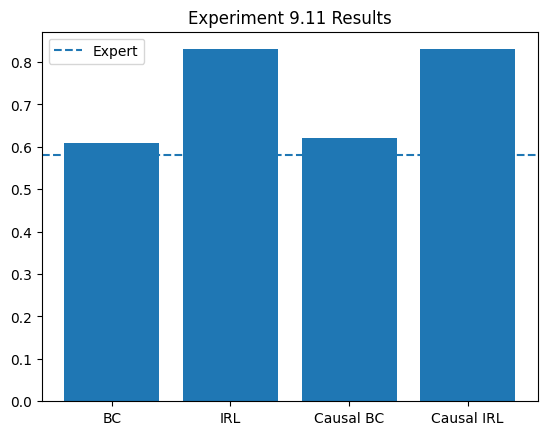

In [12]:
labels = ['BC', 'IRL', 'Causal BC', 'Causal IRL']
values = [bc_results, irl_results, causal_bc_results, causal_irl_results]

plt.figure()
plt.bar(labels, values)
plt.axhline(y=expert_results, linestyle='--', label='Expert')
plt.title('Experiment 9.11 Results')
plt.legend()
plt.show()